In [16]:
import torch

print("PyTorch version:", torch.__version__)
print("MPS disponible:", torch.backends.mps.is_available())
print("MPS construit:", torch.backends.mps.is_built())

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.randn(1000, 1000).to(device)
    print("Test MPS réussi!")

PyTorch version: 2.8.0
MPS disponible: True
MPS construit: True
Test MPS réussi!


In [ ]:
import os
import json
import h5py
import numpy as np
import librosa
import shutil
from pathlib import Path

def audio_to_h5_from_files(file_list, h5_path, sr=16000, r=4, patch_size=1024):
    """
    Convertit une liste de fichiers audio (.wav, .flac) en un fichier .h5 contenant les données LR et HR.
    Args:
        file_list (list): liste des chemins vers les fichiers audio
        h5_path (str): chemin du fichier de sortie .h5
        sr (int): sample rate cible
        r (int): facteur de sous-échantillonnage (ex: 4 → HR=16kHz, LR=4kHz)
        patch_size (int): taille des patches pour l'entraînement
    """
    X_list, Y_list = [], []
    
    # Extensions audio supportées
    supported_extensions = [".wav", ".flac"]
    
    for audio_path in file_list:
        # Vérifier l'extension du fichier
        file_extension = os.path.splitext(audio_path)[1].lower()
        if file_extension not in supported_extensions:
            continue
            
        # print(f"Processing {audio_path}...")
        
        # Vérifier si le fichier existe
        if not os.path.exists(audio_path):
            print(f"Warning: File {audio_path} not found, skipping...")
            continue
            
        try:
            # Charger audio HR (librosa supporte automatiquement .wav et .flac)
            y_hr, _ = librosa.load(audio_path, sr=sr)
            
            # Créer la version LR en sous-échantillonnant
            y_lr = y_hr[::r]
            
            # Remettre y_lr à la même longueur que y_hr via upsampling simple
            y_lr_up = librosa.resample(y_lr, orig_sr=sr//r, target_sr=sr)
            
            # Ajuster la taille pour multiples de patch_size
            min_len = min(len(y_hr), len(y_lr_up))
            y_hr = y_hr[:min_len]
            y_lr_up = y_lr_up[:min_len]
            
            # Découper en patches
            n_patches = min_len // patch_size
            for i in range(n_patches):
                start = i * patch_size
                end = start + patch_size
                X_list.append(y_lr_up[start:end])
                Y_list.append(y_hr[start:end])
                
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            continue
    
    if not X_list:
        print(f"Warning: No valid patches found for {h5_path}")
        return
    
    # Conversion en numpy
    X = np.array(X_list, dtype=np.float32)
    Y = np.array(Y_list, dtype=np.float32)
    
    # Sauvegarde dans h5
    with h5py.File(h5_path, "w") as hf:
        hf.create_dataset("X", data=X)
        hf.create_dataset("Y", data=Y)
    
    print(f"Saved {X.shape[0]} patches to {h5_path}")

def process_json_to_h5(json_path, output_dir=".", sr=16000, r=4, patch_size=1024):
    """
    Traite le fichier JSON pour convertir le premier bloc d'entraînement et les données de validation en H5.
    Args:
        json_path (str): chemin vers le fichier JSON
        output_dir (str): répertoire de sortie pour les fichiers .h5
        sr (int): sample rate cible
        r (int): facteur de sous-échantillonnage
        patch_size (int): taille des patches
    """
    # Charger le fichier JSON
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Créer le répertoire de sortie s'il n'existe pas
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Traiter le premier bloc d'entraînement
    if data.get("train_blocks") and len(data["train_blocks"]) > 0:
        first_block = data["train_blocks"][0]
        if first_block.get("files"):
            print(f"Processing first training block with {len(first_block['files'])} files...")
            train_h5_path = os.path.join(output_dir, "train281.h5")
            audio_to_h5_from_files(
                file_list=first_block["files"],
                h5_path=train_h5_path,
                sr=sr,
                r=r,
                patch_size=patch_size
            )
        else:
            print("Warning: First training block has no files")
    else:
        print("Warning: No training blocks found in JSON")
    
    # Traiter les données de validation
    if data.get("val") and data["val"].get("files"):
        print(f"Processing validation data with {len(data['val']['files'])} files...")
        val_h5_path = os.path.join(output_dir, "val281.h5")
        audio_to_h5_from_files(
            file_list=data["val"]["files"],
            h5_path=val_h5_path,
            sr=sr,
            r=r,
            patch_size=patch_size
        )
    else:
        print("Warning: No validation files found in JSON")

    if data.get("test") and data["test"].get("files"):
        print(f"Processing test data with {len(data['test']['files'])} files...")
        test_h5_path = os.path.join(output_dir, "test281.h5")
        audio_to_h5_from_files(
            file_list=data["test"]["files"],
            h5_path=test_h5_path,
            sr=sr,
            r=r,
            patch_size=patch_size
        )
    else:
        print("Warning: No test files found in JSON")

def main():
    # Paramètres
    json_file = "single_speaker_splits_p281.json"
    output_directory = "vctk_single_dataset" 
    
    # Traitement
    process_json_to_h5(
        json_path=json_file,
        output_dir=output_directory,
        sr=16000,
        r=4,
        patch_size=1024
    )

if __name__ == "__main__":
    main()

True

In [2]:
!python3 --version

Python 3.9.6


In [4]:
import tensorflow as tf
# import keras
import h5py
import numpy as np
import scipy

print("TensorFlow:", tf.__version__)
# print("Keras:", keras.__version__)
print("h5py:", h5py.__version__)
print("NumPy:", np.__version__)
print("SciPy:", scipy.__version__)


TensorFlow: 2.19.0
h5py: 3.13.0
NumPy: 2.0.2
SciPy: 1.13.1


In [1]:
from scipy import interpolate

def spline_up(x_lr, r):
    """ Interpolation par splines cubiques pour le pré-traitement"""
    x_lr = x_lr.flatten() # Assurez-vous que x_lr est un tableau 1D
    x_hr_len = len(x_lr) * r # r est le factor de sur-échantillonnage, le high-res sera r fois plus long que le low-res
    x_sp = np.zeros(x_hr_len) 
    i_lr = np.arange(x_hr_len, step=r) # Indices du low-res
    i_hr = np.arange(x_hr_len) # Indices du high-res, indices à interpoler
    f = interpolate.splrep(i_lr, x_lr)
    x_sp = interpolate.splev(i_hr, f) # Interpolation spline
    return x_sp

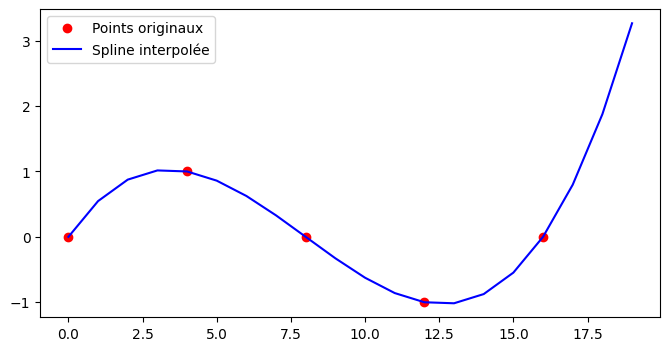

In [2]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

# Signal basse résolution
x_lr = np.array([0, 1, 0, -1, 0])  
r = 4

x_sp = spline_up(x_lr, r)

# Affichage
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(x_lr))*r, x_lr, "ro", label="Points originaux")
plt.plot(x_sp, "b-", label="Spline interpolée")
plt.legend()
plt.show()


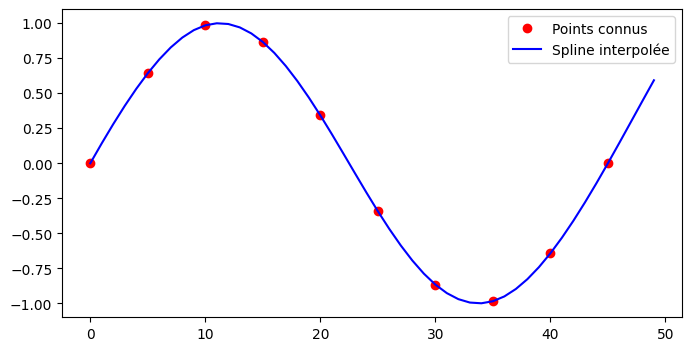

In [3]:
# Signal basse résolution : sinus
t = np.linspace(0, 2*np.pi, 10)
x_lr = np.sin(t)

x_sp = spline_up(x_lr, r=5)

plt.figure(figsize=(8,4))
plt.plot(np.arange(len(x_lr))*5, x_lr, "ro", label="Points connus")
plt.plot(x_sp, "b-", label="Spline interpolée")
plt.legend()
plt.show()

In [1]:
import os
import random
import torch
import torchaudio
import numpy as np
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
import json
from pathlib import Path

class VCTKSplitter:
    def __init__(self, vctk_path, seed=42):
        self.vctk_path = Path(vctk_path)
        self.seed = seed
        random.seed(seed)
        np.random.seed(seed)
        
    def analyze_speakers(self):
        """Analyse les caractéristiques des locuteurs pour un split intelligent"""
        speakers_info = defaultdict(lambda: {'files': [], 'total_duration': 0})
        
        # Scanner tous les fichiers audio
        audio_files = list(self.vctk_path.glob('*.wav'))
        
        for file_path in audio_files:
            speaker_id = file_path.stem.split('_')[0]  # p225_001.wav -> p225
            speakers_info[speaker_id]['files'].append(str(file_path))
            
            # Optionnel: calculer la durée pour un split plus équilibré
            try:
                waveform, sample_rate = torchaudio.load(file_path)
                duration = waveform.shape[1] / sample_rate
                speakers_info[speaker_id]['total_duration'] += duration
            except:
                # Si erreur de lecture, estimer durée moyenne
                speakers_info[speaker_id]['total_duration'] += 3.0
        
        return dict(speakers_info)
    
    def create_splits(self, num_train_blocks=16, val_ratio=0.05, test_ratio=0.05):
        """
        Crée les splits recommandés:
        - 16 blocs d'entraînement par locuteurs
        - 1 set de validation stratifié constant  
        - 1 set de test
        """
        speakers_info = self.analyze_speakers()
        all_speakers = list(speakers_info.keys())
        total_speakers = len(all_speakers)
        
        print(f"Total speakers found: {total_speakers}")
        
        # Calculer les tailles
        num_test = max(1, int(total_speakers * test_ratio))
        num_val = max(1, int(total_speakers * val_ratio))
        num_train = total_speakers - num_test - num_val
        
        print(f"Split: {num_train} train, {num_val} val, {num_test} test speakers")
        
        # Mélanger et diviser
        random.shuffle(all_speakers)
        
        test_speakers = all_speakers[:num_test]
        val_speakers = all_speakers[num_test:num_test + num_val]
        train_speakers = all_speakers[num_test + num_val:]
        
        # Créer les blocs d'entraînement
        speakers_per_block = len(train_speakers) // num_train_blocks
        train_blocks = []
        
        for i in range(num_train_blocks):
            start_idx = i * speakers_per_block
            end_idx = (i + 1) * speakers_per_block if i < num_train_blocks - 1 else len(train_speakers)
            
            block_speakers = train_speakers[start_idx:end_idx]
            block_files = []
            
            for speaker in block_speakers:
                block_files.extend(speakers_info[speaker]['files'])
            
            train_blocks.append({
                'speakers': block_speakers,
                'files': block_files,
                'num_files': len(block_files)
            })
            
            print(f"Block {i+1}: {len(block_speakers)} speakers, {len(block_files)} files")
        
        # Créer sets de validation et test
        val_files = []
        for speaker in val_speakers:
            val_files.extend(speakers_info[speaker]['files'])
            
        test_files = []
        for speaker in test_speakers:
            test_files.extend(speakers_info[speaker]['files'])
        
        splits = {
            'train_blocks': train_blocks,
            'val': {
                'speakers': val_speakers,
                'files': val_files,
                'num_files': len(val_files)
            },
            'test': {
                'speakers': test_speakers,
                'files': test_files,
                'num_files': len(test_files)
            }
        }
        
        return splits
    
    def save_splits(self, splits, save_path="./data_splits.json"):
        """Sauvegarde les splits pour reproductibilité"""
        with open(save_path, 'w') as f:
            json.dump(splits, f, indent=2)
        print(f"Splits saved to {save_path}")
    
    def load_splits(self, load_path="./data_splits.json"):
        """Charge des splits sauvegardés"""
        with open(load_path, 'r') as f:
            return json.load(f)

In [2]:
path = "/Users/rovafifaliana/.cache/kagglehub/datasets/awsaf49/vctk-sr16k-dataset/versions/1/wavs"
print("Path to VCTK dataset:", path)

Path to VCTK dataset: /Users/rovafifaliana/.cache/kagglehub/datasets/awsaf49/vctk-sr16k-dataset/versions/1/wavs


In [9]:
vctk_path = path  # Modifier ce chemin
splitter = VCTKSplitter(vctk_path)

print("Creating data splits...")
splits = splitter.create_splits(num_train_blocks=16, val_ratio=(0.05/2), test_ratio=0.05)
splitter.save_splits(splits)

Creating data splits...
Total speakers found: 108
Split: 101 train, 2 val, 5 test speakers
Block 1: 6 speakers, 2241 files
Block 2: 6 speakers, 2096 files
Block 3: 6 speakers, 2634 files
Block 4: 6 speakers, 2151 files
Block 5: 6 speakers, 2554 files
Block 6: 6 speakers, 2383 files
Block 7: 6 speakers, 2442 files
Block 8: 6 speakers, 2525 files
Block 9: 6 speakers, 2576 files
Block 10: 6 speakers, 2340 files
Block 11: 6 speakers, 2512 files
Block 12: 6 speakers, 2544 files
Block 13: 6 speakers, 2404 files
Block 14: 6 speakers, 2430 files
Block 15: 6 speakers, 2497 files
Block 16: 11 speakers, 4540 files
Splits saved to ./data_splits.json


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/vctk-sr16k-dataset")

print("Path to dataset files:", path)

Resuming download from 2245001216 bytes (1040466703 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/awsaf49/vctk-sr16k-dataset?dataset_version_number=1 (2245001216/3285467919) bytes left.


100%|██████████| 3.06G/3.06G [14:53<00:00, 1.16MB/s]

Extracting files...


Path to dataset files: /Users/rovafifaliana/.cache/kagglehub/datasets/awsaf49/vctk-sr16k-dataset/versions/1


In [7]:
993 / 163

6.0920245398773005

In [5]:
1 - 0.07

0.9299999999999999

In [6]:
((1 - 0.07) * 20) / 100

0.18599999999999997

In [3]:
model_path = "model_afilm_single_2.pth_epoch10.pth"
val_data_path = "vctk_single_dataset/test281.h5"
model_type = "afilm"
layers = 4
scale = 2

In [4]:
# Setup device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [ ]:
import sys

sys.path.append("codes")
print (sys.path)

['/Users/rovafifaliana/.pyenv/versions/3.10.14/lib/python310.zip', '/Users/rovafifaliana/.pyenv/versions/3.10.14/lib/python3.10', '/Users/rovafifaliana/.pyenv/versions/3.10.14/lib/python3.10/lib-dynload', '', '/Users/rovafifaliana/.pyenv/versions/afilm_env/lib/python3.10/site-packages', '/Users/rovafifaliana/Documents/MISA/machine_learning/evaluation2/AFiLM_conversion/', '/Users/rovafifaliana/Documents/MISA/machine_learning/evaluation2/AFiLM_conversion/codes', '/Users/rovafifaliana/Documents/MISA/machine_learning/evaluation2/AFiLM_conversion/codes']


In [14]:
from models.afilm import get_afilm
from models.tfilm import get_tfilm

# Load model
if model_type == 'afilm':
    model = get_afilm(n_layers=layers, scale=scale)
elif model_type == 'tfilm':
    model = get_tfilm(n_layers=layers, scale=scale)
else:
    raise ValueError(f"Unknown model type: {model_type}")

In [16]:
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

AFiLMNet(
  (down_blocks): ModuleList(
    (0): Conv1d(1, 128, kernel_size=(65,), stride=(1,), padding=same, dilation=(2,))
    (1): Conv1d(128, 256, kernel_size=(33,), stride=(1,), padding=same, dilation=(2,))
    (2): Conv1d(256, 512, kernel_size=(17,), stride=(1,), padding=same, dilation=(2,))
    (3): Conv1d(512, 512, kernel_size=(9,), stride=(1,), padding=same, dilation=(2,))
  )
  (bottleneck_conv): Conv1d(512, 512, kernel_size=(9,), stride=(1,), padding=same, dilation=(2,))
  (up_blocks): ModuleList(
    (0): Conv1d(768, 512, kernel_size=(9,), stride=(1,), padding=same, dilation=(2,))
    (1): Conv1d(768, 512, kernel_size=(17,), stride=(1,), padding=same, dilation=(2,))
    (2): Conv1d(512, 256, kernel_size=(33,), stride=(1,), padding=same, dilation=(2,))
    (3): Conv1d(256, 128, kernel_size=(65,), stride=(1,), padding=same, dilation=(2,))
  )
  (out_conv): Conv1d(128, 2, kernel_size=(9,), stride=(1,), padding=(4,))
)

In [17]:
import torch.nn as nn

# Evaluate
criterion = nn.MSELoss()
total_loss = 0.0
num_samples = 0

In [19]:
import h5py

print("Loading validation data...")
with h5py.File(val_data_path, "r") as f:
    X_val = torch.tensor(f["X"][:], dtype=torch.float32)
    Y_val = torch.tensor(f["Y"][:], dtype=torch.float32)

    print(f"Validation data shape: X={X_val.shape}, Y={Y_val.shape}")

Loading validation data...
Validation data shape: X=torch.Size([1166, 1024]), Y=torch.Size([1166, 1024])


In [20]:
from torch.utils.data import TensorDataset, DataLoader

val_loader = DataLoader(TensorDataset(X_val, Y_val), batch_size=16)

print("Evaluating...")
with torch.no_grad():
    for X, Y in val_loader:
        X, Y = X.to(device), Y.to(device)
        outputs = model(X)

        print(f"Output shape: {outputs.shape}, Target shape: {Y.shape}")
        print(f"Outputs.dim(): {outputs.dim()}, Outputs.shape: {outputs.shape}")
        
        # Handle potential shape issues (same as in your training script)
        if outputs.dim() == 3 and outputs.shape[-1] == 2:
            print("Condition vérifiée")
            outputs = outputs[:, :, 0]
        
        loss = criterion(outputs, Y)
        total_loss += loss.item() * X.size(0)
        num_samples += X.size(0)

Evaluating...
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1024])
Outputs.dim(): 2, Outputs.shape: torch.Size([16, 1024])
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1024])
Outputs.dim(): 2, Outputs.shape: torch.Size([16, 1024])
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1024])
Outputs.dim(): 2, Outputs.shape: torch.Size([16, 1024])
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1024])
Outputs.dim(): 2, Outputs.shape: torch.Size([16, 1024])
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1024])
Outputs.dim(): 2, Outputs.shape: torch.Size([16, 1024])
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1024])
Outputs.dim(): 2, Outputs.shape: torch.Size([16, 1024])
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1024])
Outputs.dim(): 2, Outputs.shape: torch.Size([16, 1024])
Output shape: torch.Size([16, 1024]), Target shape: torch.Size([16, 1

In [21]:
avg_loss = total_loss / num_samples
print(f"Validation Loss: {avg_loss:.6f}")

Validation Loss: 0.000392


# dataset VCTK single

## Display x2

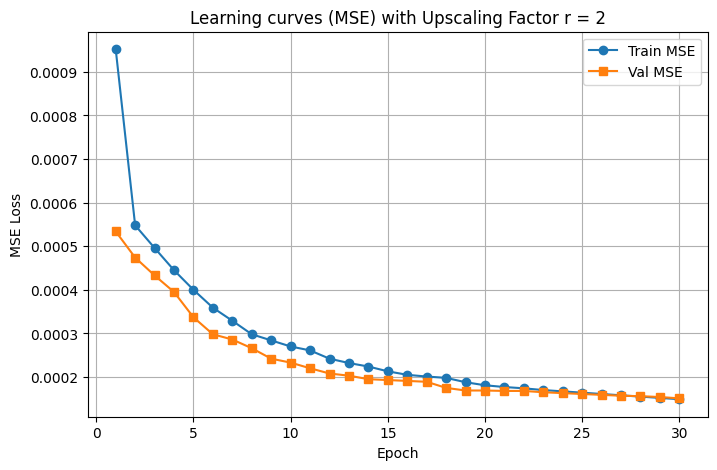

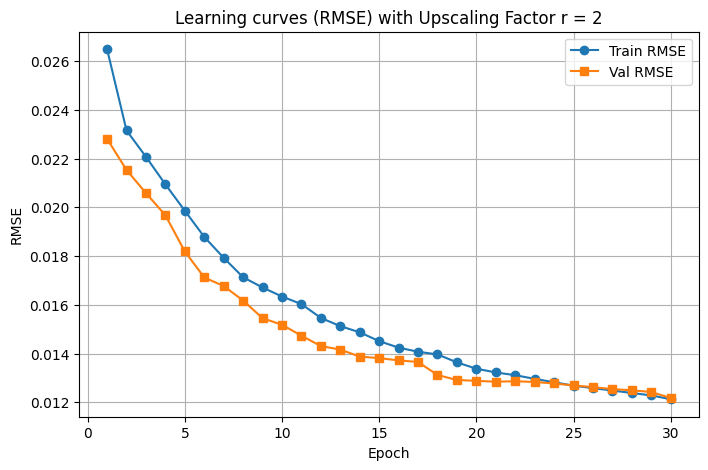

In [17]:
import matplotlib.pyplot as plt

# Données complètes du log d'entraînement (époques 1-30)
epochs = list(range(1, 31))

train_mse = [
    0.000952, 0.000548, 0.000496, 0.000445, 0.000400,
    0.000359, 0.000329, 0.000298, 0.000284, 0.000270,
    0.000261, 0.000242, 0.000232, 0.000224,
    0.000213, 0.000205, 0.000201, 0.000198, 0.000188,
    0.000181, 0.000177, 0.000174,
    0.000170, 0.000167, 0.000164, 0.000161, 0.000158,
    0.000155, 0.000152,
    0.000149
]

val_mse = [
    0.000534, 0.000474, 0.000433, 0.000395, 0.000337,
    0.000298, 0.000286, 0.000266, 0.000242, 0.000233,
    0.000220, 0.000208, 0.000203, 0.000195,
    0.000193, 0.000191, 0.000189, 0.000175, 0.000169,
    0.000169, 0.000168, 0.000168,
    0.000165, 0.000163, 0.000161, 0.000159, 0.000157,
    0.000156, 0.000154,
    0.000151
]

train_rmse = [
    0.026487, 0.023154, 0.022072, 0.020941, 0.019859,
    0.018785, 0.017927, 0.017127, 0.016710, 0.016337,
    0.016028, 0.015459, 0.015124, 0.014869,
    0.014508, 0.014240, 0.014073, 0.013962, 0.013637,
    0.013376, 0.013223, 0.013109,
    0.012960, 0.012820, 0.012680, 0.012580, 0.012480,
    0.012380, 0.012280,
    0.012124
]

val_rmse = [
    0.022807, 0.021534, 0.020583, 0.019672, 0.018188,
    0.017121, 0.016768, 0.016174, 0.015449, 0.015178,
    0.014731, 0.014306, 0.014160, 0.013873,
    0.013810, 0.013718, 0.013651, 0.013119, 0.012913,
    0.012878, 0.012843, 0.012862,
    0.012830, 0.012770, 0.012690, 0.012620, 0.012540,
    0.012490, 0.012420,
    0.012174
]

# Tracé MSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_mse, marker='o', label="Train MSE")
plt.plot(epochs, val_mse, marker='s', label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning curves (MSE) with Upscaling Factor r = 2")
plt.legend()
plt.grid(True)
plt.show()

# Tracé RMSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_rmse, marker='o', label="Train RMSE")
plt.plot(epochs, val_rmse, marker='s', label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Learning curves (RMSE) with Upscaling Factor r = 2")
plt.legend()
plt.grid(True)
plt.show()


## Display x4

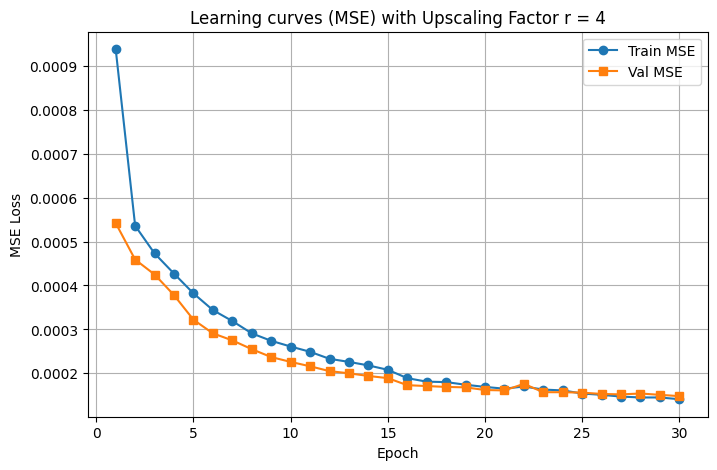

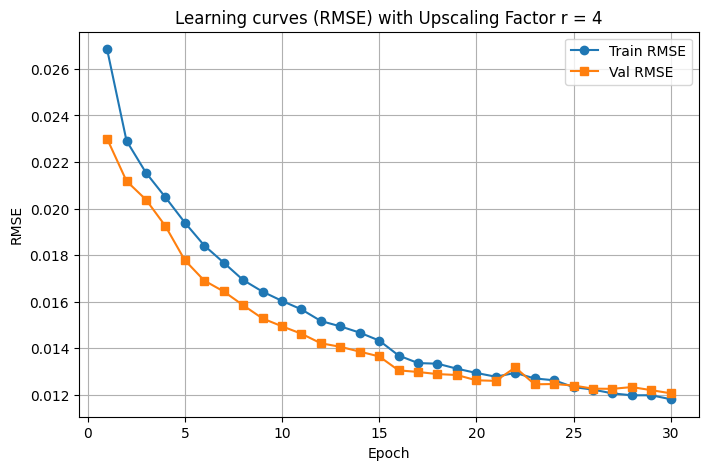

In [18]:
import matplotlib.pyplot as plt

# Données complètes du log d'entraînement (époques 1-30)
epochs = list(range(1, 31))

train_mse = [
    0.000938, 0.000536, 0.000473, 0.000427, 0.000382,
    0.000344, 0.000319, 0.000291, 0.000274, 0.000261,
    0.000249, 0.000233, 0.000226, 0.000218, 0.000208,
    0.000189, 0.000181, 0.000180, 0.000174, 0.000169,
    0.000165, 0.000170, 0.000163, 0.000161, 0.000154,
    0.000151, 0.000147, 0.000145, 0.000145, 0.000141
]

val_mse = [
    0.000542, 0.000459, 0.000425, 0.000378, 0.000322,
    0.000291, 0.000275, 0.000255, 0.000237, 0.000226,
    0.000216, 0.000205, 0.000200, 0.000194, 0.000189,
    0.000173, 0.000171, 0.000169, 0.000168, 0.000162,
    0.000161, 0.000176, 0.000157, 0.000157, 0.000156,
    0.000153, 0.000152, 0.000154, 0.000151, 0.000148
]

train_rmse = [
    0.026847, 0.022911, 0.021538, 0.020485, 0.019395,
    0.018410, 0.017673, 0.016926, 0.016427, 0.016029,
    0.015664, 0.015165, 0.014935, 0.014665, 0.014325,
    0.013682, 0.013357, 0.013330, 0.013115, 0.012932,
    0.012770, 0.012935, 0.012696, 0.012618, 0.012323,
    0.012217, 0.012055, 0.011971, 0.011974, 0.011803
]

val_rmse = [
    0.023001, 0.021181, 0.020382, 0.019247, 0.017778,
    0.016902, 0.016435, 0.015843, 0.015274, 0.014938,
    0.014617, 0.014208, 0.014056, 0.013849, 0.013642,
    0.013044, 0.012974, 0.012883, 0.012844, 0.012616,
    0.012592, 0.013168, 0.012444, 0.012456, 0.012392,
    0.012257, 0.012250, 0.012325, 0.012192, 0.012058
]


# Tracé MSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_mse, marker='o', label="Train MSE")
plt.plot(epochs, val_mse, marker='s', label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning curves (MSE) with Upscaling Factor r = 4")
plt.legend()
plt.grid(True)
plt.show()

# Tracé RMSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_rmse, marker='o', label="Train RMSE")
plt.plot(epochs, val_rmse, marker='s', label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Learning curves (RMSE) with Upscaling Factor r = 4")
plt.legend()
plt.grid(True)
plt.show()

## Display x8

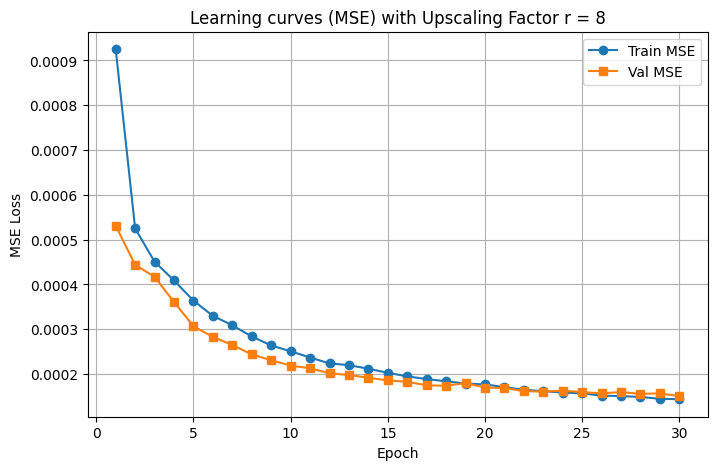

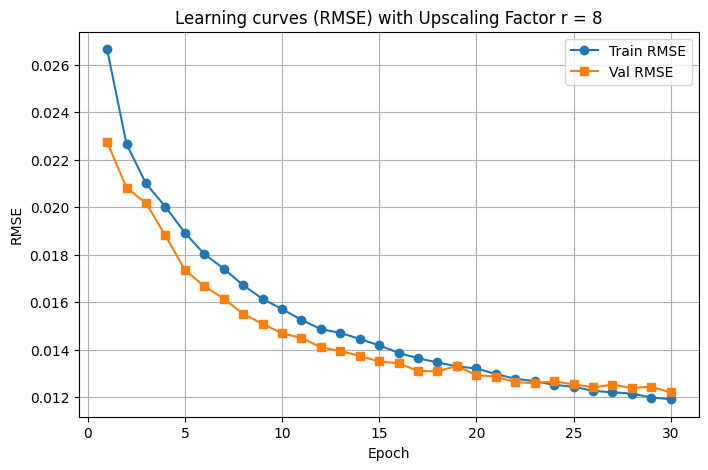

In [19]:
import matplotlib.pyplot as plt

# Données complètes du log d'entraînement (époques 1-30)
epochs = list(range(1, 31))

train_mse = [
    0.000925, 0.000525, 0.000451, 0.000409, 0.000364,
    0.000330, 0.000309, 0.000284, 0.000264, 0.000251,
    0.000237, 0.000224, 0.000220, 0.000212, 0.000203,
    0.000195, 0.000189, 0.000184, 0.000179, 0.000177,
    0.000171, 0.000165, 0.000162, 0.000159, 0.000157,
    0.000152, 0.000151, 0.000149, 0.000145, 0.000144
]

val_mse = [
    0.000531, 0.000444, 0.000417, 0.000361, 0.000307,
    0.000283, 0.000265, 0.000244, 0.000231, 0.000219,
    0.000213, 0.000202, 0.000198, 0.000192, 0.000186,
    0.000183, 0.000175, 0.000174, 0.000180, 0.000170,
    0.000169, 0.000162, 0.000161, 0.000163, 0.000160,
    0.000157, 0.000160, 0.000156, 0.000157, 0.000151
]

train_rmse = [
    0.026658, 0.022668, 0.021005, 0.020029, 0.018930,
    0.018035, 0.017419, 0.016725, 0.016144, 0.015722,
    0.015260, 0.014871, 0.014716, 0.014459, 0.014191,
    0.013872, 0.013647, 0.013472, 0.013302, 0.013217,
    0.012983, 0.012782, 0.012683, 0.012526, 0.012449,
    0.012274, 0.012212, 0.012160, 0.011994, 0.011922
]

val_rmse = [
    0.022756, 0.020827, 0.020180, 0.018821, 0.017367,
    0.016682, 0.016160, 0.015512, 0.015099, 0.014698,
    0.014502, 0.014110, 0.013953, 0.013743, 0.013512,
    0.013432, 0.013116, 0.013092, 0.013328, 0.012936,
    0.012877, 0.012638, 0.012599, 0.012675, 0.012550,
    0.012422, 0.012531, 0.012396, 0.012447, 0.012206
]


# Tracé MSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_mse, marker='o', label="Train MSE")
plt.plot(epochs, val_mse, marker='s', label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning curves (MSE) with Upscaling Factor r = 8")
plt.legend()
plt.grid(True)
plt.show()

# Tracé RMSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_rmse, marker='o', label="Train RMSE")
plt.plot(epochs, val_rmse, marker='s', label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Learning curves (RMSE) with Upscaling Factor r = 8")
plt.legend()
plt.grid(True)
plt.show()


# dataset librispeech with one speaker
## r = 2

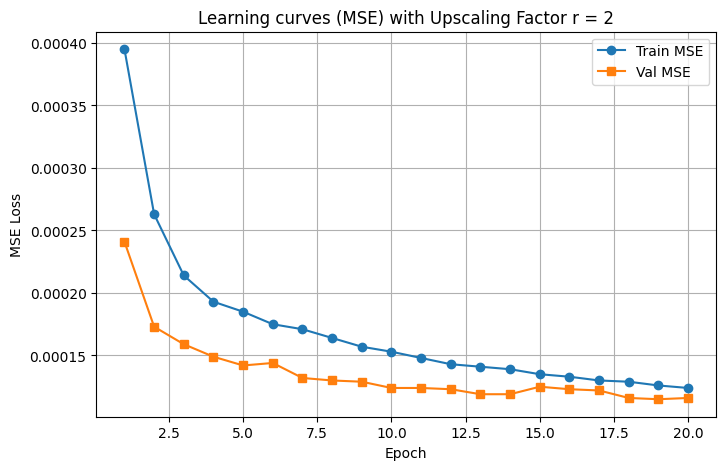

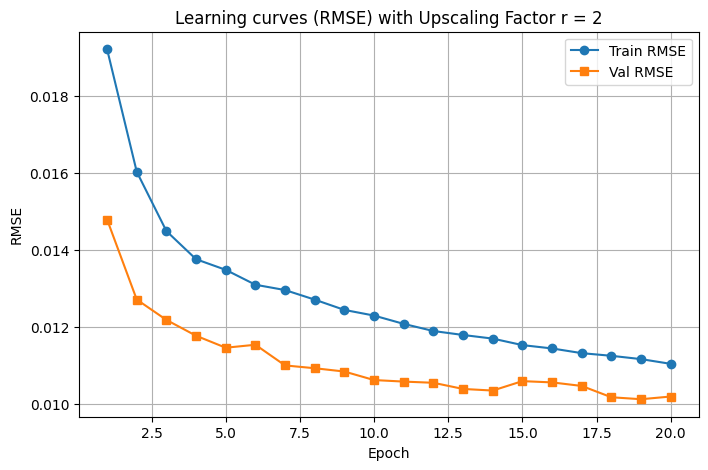

In [20]:
import matplotlib.pyplot as plt

# Données complètes du log d'entraînement (époques 1-20)
epochs = list(range(1, 21))

train_mse = [
    0.000395, 0.000263, 0.000214, 0.000193, 0.000185,
    0.000175, 0.000171, 0.000164, 0.000157, 0.000153,
    0.000148, 0.000143, 0.000141, 0.000139, 0.000135,
    0.000133, 0.000130, 0.000129, 0.000126, 0.000124
]

val_mse = [
    0.000241, 0.000173, 0.000159, 0.000149, 0.000142,
    0.000144, 0.000132, 0.000130, 0.000129, 0.000124,
    0.000124, 0.000123, 0.000119, 0.000119, 0.000125,
    0.000123, 0.000122, 0.000116, 0.000115, 0.000116
]

train_rmse = [
    0.019211, 0.016027, 0.014486, 0.013755, 0.013479,
    0.013092, 0.012954, 0.012705, 0.012438, 0.012291,
    0.012075, 0.011890, 0.011787, 0.011693, 0.011524,
    0.011437, 0.011315, 0.011246, 0.011160, 0.011037
]

val_rmse = [
    0.014787, 0.012707, 0.012178, 0.011767, 0.011456,
    0.011533, 0.010996, 0.010923, 0.010837, 0.010616,
    0.010576, 0.010545, 0.010385, 0.010343, 0.010588,
    0.010555, 0.010463, 0.010169, 0.010118, 0.010188
]



# Tracé MSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_mse, marker='o', label="Train MSE")
plt.plot(epochs, val_mse, marker='s', label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning curves (MSE) with Upscaling Factor r = 2")
plt.legend()
plt.grid(True)
plt.show()

# Tracé RMSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_rmse, marker='o', label="Train RMSE")
plt.plot(epochs, val_rmse, marker='s', label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Learning curves (RMSE) with Upscaling Factor r = 2")
plt.legend()
plt.grid(True)
plt.show()


## r = 4

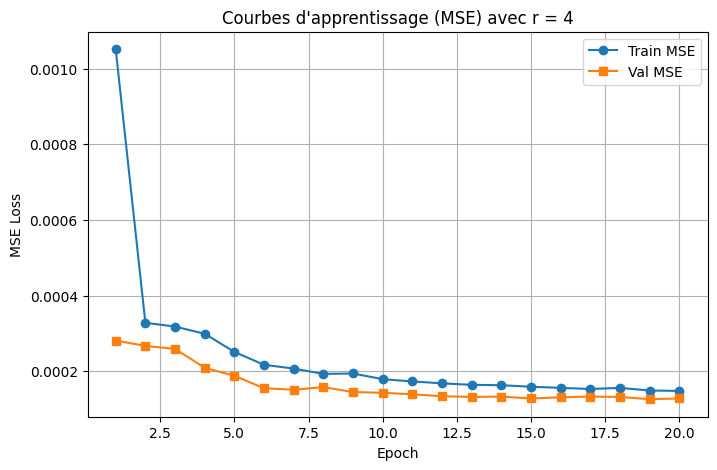

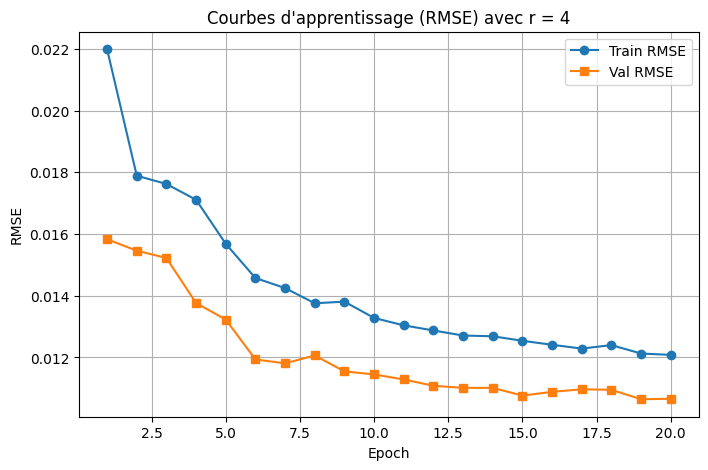

In [ ]:
# Données complètes du log d'entraînement (époques 1-20)
epochs = list(range(1, 21))

train_mse = [
    0.001051, 0.000328, 0.000318, 0.000299, 0.000251,
    0.000217, 0.000207, 0.000193, 0.000194, 0.000179,
    0.000173, 0.000168, 0.000164, 0.000163, 0.000159,
    0.000156, 0.000153, 0.000156, 0.000149, 0.000148
]

val_mse = [
    0.000281, 0.000267, 0.000259, 0.000209, 0.000188,
    0.000155, 0.000151, 0.000158, 0.000145, 0.000143,
    0.000139, 0.000134, 0.000132, 0.000133, 0.000128,
    0.000131, 0.000133, 0.000132, 0.000126, 0.000128
]

train_rmse = [
    0.021993, 0.017892, 0.017624, 0.017112, 0.015685,
    0.014575, 0.014250, 0.013756, 0.013810, 0.013281,
    0.013041, 0.012875, 0.012711, 0.012687, 0.012540,
    0.012411, 0.012287, 0.012401, 0.012127, 0.012084
]

val_rmse = [
    0.015832, 0.015462, 0.015224, 0.013765, 0.013228,
    0.011936, 0.011809, 0.012065, 0.011549, 0.011450,
    0.011287, 0.011082, 0.011014, 0.011014, 0.010764,
    0.010884, 0.010968, 0.010951, 0.010646, 0.010660
]

# Tracé MSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_mse, marker='o', label="Train MSE")
plt.plot(epochs, val_mse, marker='s', label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning curves (MSE) with Upscaling Factor r = 4")
plt.legend()
plt.grid(True)
plt.show()

# Tracé RMSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_rmse, marker='o', label="Train RMSE")
plt.plot(epochs, val_rmse, marker='s', label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Learning curves (RMSE) with Upscaling Factor r = 4")
plt.legend()
plt.grid(True)
plt.show()


## r = 8

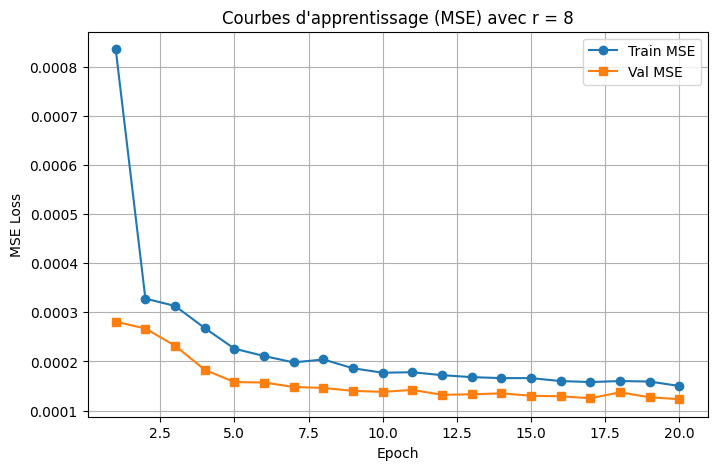

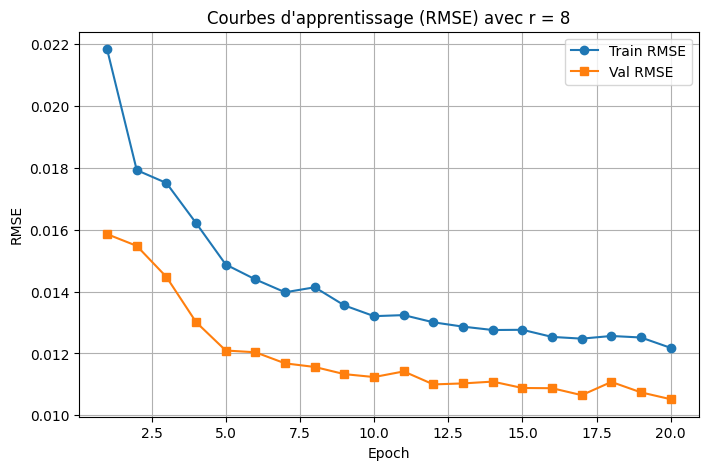

In [ ]:
# Données complètes du log d'entraînement (époques 1-20)
epochs = list(range(1, 21))

train_mse = [
    0.000836, 0.000328, 0.000313, 0.000268, 0.000226,
    0.000211, 0.000198, 0.000204, 0.000186, 0.000177,
    0.000178, 0.000172, 0.000168, 0.000166, 0.000166,
    0.000160, 0.000158, 0.000160, 0.000159, 0.000150
]

val_mse = [
    0.000281, 0.000267, 0.000232, 0.000183, 0.000158,
    0.000157, 0.000148, 0.000146, 0.000140, 0.000138,
    0.000142, 0.000132, 0.000133, 0.000135, 0.000130,
    0.000129, 0.000125, 0.000137, 0.000127, 0.000123
]

train_rmse = [
    0.021836, 0.017926, 0.017510, 0.016214, 0.014874,
    0.014392, 0.013976, 0.014138, 0.013551, 0.013204,
    0.013238, 0.013005, 0.012865, 0.012756, 0.012763,
    0.012533, 0.012477, 0.012563, 0.012514, 0.012178
]

val_rmse = [
    0.015856, 0.015477, 0.014473, 0.013011, 0.012093,
    0.012036, 0.011678, 0.011561, 0.011329, 0.011235,
    0.011417, 0.010997, 0.011029, 0.011088, 0.010881,
    0.010874, 0.010650, 0.011077, 0.010739, 0.010518
]

# Tracé MSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_mse, marker='o', label="Train MSE")
plt.plot(epochs, val_mse, marker='s', label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning curves (MSE) with Upscaling Factor r = 8")
plt.legend()
plt.grid(True)
plt.show()

# Tracé RMSE
plt.figure(figsize=(8,5))
plt.plot(epochs, train_rmse, marker='o', label="Train RMSE")
plt.plot(epochs, val_rmse, marker='s', label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Learning curves (RMSE) with Upscaling Factor r = 8")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
aout = 200 + 100.928 + 25.89 + 0.7 + 32.8 + 45.5 + 200 + 49 + 74 + 30 + 90 + 12.2
juillet = 400 + 12.2 + 28 + 0.7 + 1200 + 700 + 300 + 49
juin = 12.2 + 300 + 104.940 + 69 + 200 + 28.6 + 0.7 + 13.5 + 200 + 350 + 49 + 58.9

print(aout)
print(juillet)
print(juin)

1161.018
2689.9
1386.8400000000001


In [6]:
4000 / aout

4.645663621434163

In [7]:
juillet - 700 - 1200

789.9000000000001

In [2]:
0.012192 - 0.012058

0.00013400000000000044